In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import missingno as msno

In [117]:
ruta = 'datos_central.xlsx'
df = pd.read_excel(ruta, engine='openpyxl')

In [118]:
# Seleccionamos la ventana de 5 días alrededor de la fecha central (2 días antes y 2 días después)
inicio_ventana = '2023-05-06'
fin_ventana = '2023-09-03'

# Filtramos el DataFrame para esta ventana de tiempo
datos_ventana = df[(df['Fecha'] >= inicio_ventana) & (df['Fecha'] <= fin_ventana)]

In [119]:
# Seleccionamos la ventana de 5 días alrededor de la fecha central (2 días antes y 2 días después)
inicio_ventana = '2023-09-03'
fin_ventana = '2023-09-04'

# Filtramos el DataFrame para esta ventana de tiempo
datos_next_day = df[(df['Fecha'] >= inicio_ventana) & (df['Fecha'] <= fin_ventana)]

In [120]:
Y = datos_ventana['Generacion_Potencial']
dummies = pd.get_dummies(datos_ventana['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_ventana['Externo'],datos_ventana['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

In [121]:

# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = 15

# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)

# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()


112


In [123]:
# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Ajustar el modelo
modelo = sm.OLS(Y, X).fit()

# Extraer y almacenar los parámetros estimados para la fecha actual
parametros_actuales = modelo.params
parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

# Convertir la columna 'Hora' en variables dummy
dummies_siguiente = pd.get_dummies(datos_next_day['Hora'], drop_first=True, prefix='h')
dummies_siguiente = dummies_siguiente.astype(float)

# Preparar las variables X para la predicción
X_siguiente = pd.concat([datos_next_day['Externo'], datos_next_day['Coordinado'], dummies_siguiente], axis=1)
X_siguiente = sm.add_constant(X_siguiente)

# Agregar interacciones como en el entrenamiento
for var in var_ind:
    for dummie in dummies_siguiente.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X_siguiente[nombre_interaccion] = X_siguiente[var] * X_siguiente[dummie]

# Asegurarse de que X_siguiente tenga las mismas columnas en el mismo orden que X
#X_siguiente = X_siguiente.reindex(columns = X.columns, fill_value=0)

# Realizar la predicción para el día siguiente
predicciones = modelo.predict(X_siguiente)

# Almacenar las predicciones
predicciones_df = pd.concat([predicciones_df, predicciones])

# Almacenar las variables utilizadas para la predicción del nuevo día
variables_prediccion_df = pd.concat([variables_prediccion_df, datos_next_day])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)


     const   Externo  Coordinado        h_8         h_9        h_10  \
0 -0.06792  0.009936    0.000136  20.810685  132.068574  159.230082   

         h_11        h_12        h_13        h_14  ...  Coordinado-h_11  \
0  171.547568  169.846579  171.191096  167.295871  ...         0.066261   

   Coordinado-h_12  Coordinado-h_13  Coordinado-h_14  Coordinado-h_15  \
0         0.082083         0.046729         0.060271         0.094061   

   Coordinado-h_16  Coordinado-h_17  Coordinado-h_18  Coordinado-h_19  \
0           0.1254         0.272409         3.388641        53.142721   

   Coordinado-h_20  
0              0.0  

[1 rows x 42 columns]
              0
0     -0.066926
1     17.513205
2    130.029012
3    170.543241
4    180.081802
5    181.936286
6    179.555372
7    177.033779
8    172.483073
9    171.873078
10   170.517915
11  1061.349834
12  4932.406451
13     0.001499
                 Fecha            Nombre  Externo  Coordinado  SExperto  \
0  2023-09-03 07:00:00  PFV FINI

# Método Matricial

In [124]:
resumen = modelo.summary()
# Mostrar el resumen del modelo
print(resumen)

                             OLS Regression Results                             
Dep. Variable:     Generacion_Potencial   R-squared:                       0.863
Model:                              OLS   Adj. R-squared:                  0.860
Method:                   Least Squares   F-statistic:                     271.6
Date:                  Tue, 12 Mar 2024   Prob (F-statistic):               0.00
Time:                          17:53:43   Log-Likelihood:                -8040.1
No. Observations:                  1680   AIC:                         1.616e+04
Df Residuals:                      1641   BIC:                         1.637e+04
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.

In [112]:
X.shape
#Y.shape

(1800, 45)

In [113]:

rank = np.linalg.matrix_rank(X)
if rank < X.shape[1]:
    print("La matriz X es de rango deficiente y tiene colinealidad.")
else:
    print("La matriz X es de rango completo.")

La matriz X es de rango deficiente y tiene colinealidad.


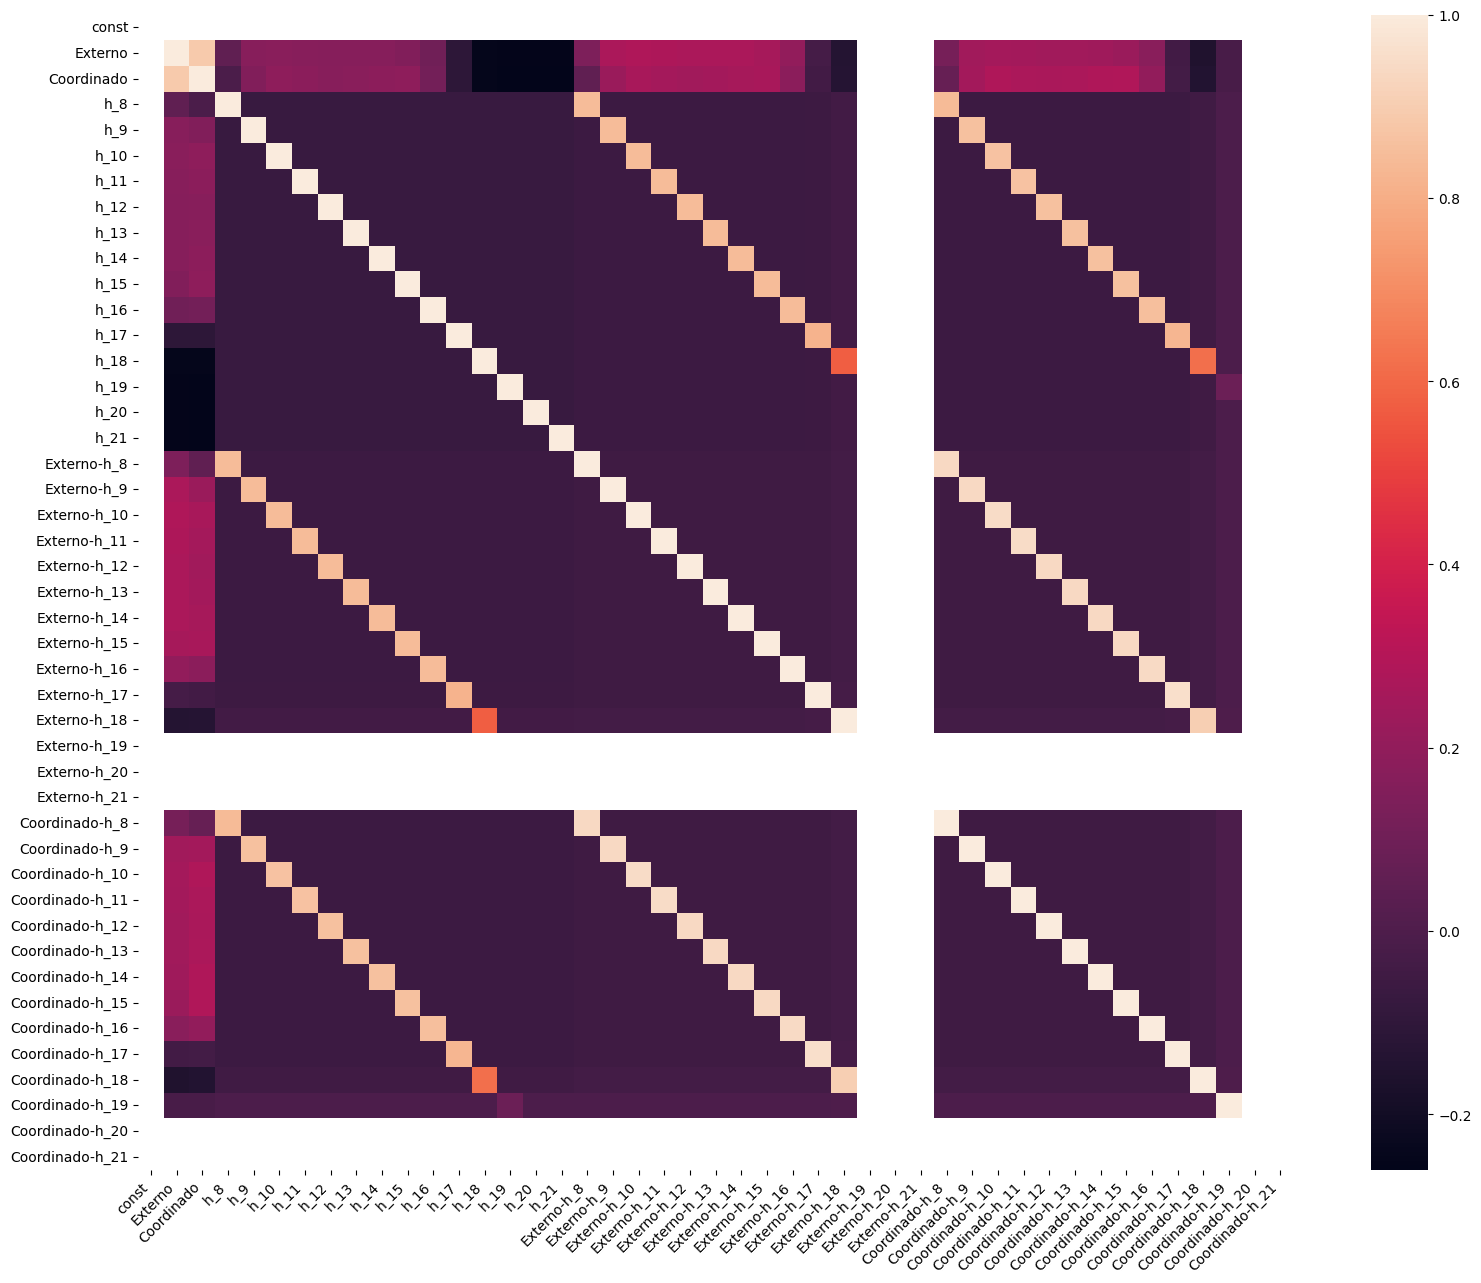

In [114]:
# Calculamos la matriz de correlación
correlation_matrix = X.corr()

# Creamos el mapa de calor utilizando seaborn
plt.figure(figsize=(20, 15))  # Puedes ajustar el tamaño según tus necesidades
# Seleccionar una paleta de colores con un buen contraste
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(correlation_matrix, square=True)
# Ajustar la visualización de los ejes si es necesario
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
# Mostramos el gráfico
plt.show()

In [115]:

# Añadir la columna de unos a X para el intercepto si aún no lo has hecho
#X = np.hstack([np.ones((X.shape[0], 1)), X])

# Calcular (X^T * X)
XTX = np.dot(X.T, X)

# Calcular la inversa de (X^T * X)
XTX_inv = np.linalg.pinv(XTX)

# Calcular (X^T * Y)
XTY = np.dot(X.T, Y)

# Calcular los coeficientes: (X^T * X)^-1 * (X^T * Y)
coeficientes = np.dot(XTX_inv, XTY)

print("Coeficientes del modelo OLS:")
print(coeficientes)



Coeficientes del modelo OLS:
[-6.79195375e-02  9.93584381e-03  1.36268742e-04  2.08106853e+01
  1.32068574e+02  1.59230081e+02  1.71547568e+02  1.69846579e+02
  1.71191096e+02  1.67295871e+02  1.55326569e+02  1.51062748e+02
  1.32589387e+02  4.54495993e+01  7.76490966e-01  6.79195374e-02
  6.79195375e-02 -7.51277450e-02 -5.72406788e-02 -3.32281542e-02
 -5.05477080e-02 -5.18335696e-02 -2.33688801e-02 -3.33210689e-02
 -3.59364377e-02 -6.00895854e-02 -1.64642376e-01  3.89749823e+00
  2.88535176e-11 -2.31226920e-11  2.61166104e-11  1.52018805e-01
  8.13800682e-02  8.86678657e-02  6.62605279e-02  8.20829258e-02
  4.67294013e-02  6.02708848e-02  9.40611116e-02  1.25399718e-01
  2.72408551e-01  3.38864072e+00  5.31427209e+01  0.00000000e+00
  0.00000000e+00]


In [87]:
XTX

array([[2.16000000e+03, 1.38590200e+05, 1.55955049e+05, ...,
        4.50000000e-02, 0.00000000e+00, 0.00000000e+00],
       [1.38590200e+05, 2.26165782e+07, 2.36132302e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55955049e+05, 2.36132302e+07, 2.77258968e+07, ...,
        2.02500000e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.50000000e-02, 0.00000000e+00, 2.02500000e-03, ...,
        2.02500000e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [116]:
diff = pd.DataFrame()
diff['Matricial'] = coeficientes
diff['No_matricial'] = parametros_df.T.values
diff['diferencia'] = diff['Matricial'] - diff['No_matricial']
diff

,Matricial,No_matricial,diferencia
0,-6.791954e-02,-6.791955e-02,8.133516e-09
1,9.935844e-03,9.935844e-03,-7.155434e-11
2,1.362687e-04,1.362690e-04,-2.163128e-10
3,2.081069e+01,2.081069e+01,-1.056642e-08
4,1.320686e+02,1.320686e+02,-9.592554e-09
5,1.592301e+02,1.592301e+02,-1.003065e-08
6,1.715476e+02,1.715476e+02,-9.640559e-09
7,1.698466e+02,1.698466e+02,-8.451707e-09
8,1.711911e+02,1.711911e+02,-7.709446e-09
9,1.672959e+02,1.672959e+02,-7.953872e-09
